# Explore
### A notebook for my initial explorations of the PCWG CESM/COSP outputs for satellite observation comparisons.
##### Initialized by Drew Camron 01/2018
---

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:32946 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
# Working directories
data_indir = (
    '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
    'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN/')

obs_indir = '/glade/p/work/jenkay/obs/COSP/CLOUDSAT/v2_Tristan/'

mask_indir = '/glade/p/work/lvank/racmo/gismask_RACMO23_0.9x1.25_con.nc'

#### Jen's dataset
Similar to before, though these data are only monthly RCP8.5 "present" and "future" CESM scenarios with scale- and definition-aware outputs (see Kay et al. submitted 2017.) **Update 02/14/2018**: will meet with Jen on 3/1 to re-define these categories to be appropriate over ice sheet. **Update 03/01/2018**: met with Jen, was pointed to `LANDOCN` simulations where reflectivity bins were redefined over land to match up with CloudSat 2CPC -> outlined in her paper revision.

In [4]:
# Reading in all years of monthly mean data
ds = xr.open_mfdataset(data_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN.cam.h0.*.nc', decode_times=False)

ds['time'] = pd.date_range('2011-01', '2025-12', freq='MS')
ds = ds.sel(lat=slice(0, 90)).sel(time=slice('2011-01-01', '2025-12-01'))

Since this first step, I've moved on to using this cell to evaluate individual variables quickly.

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


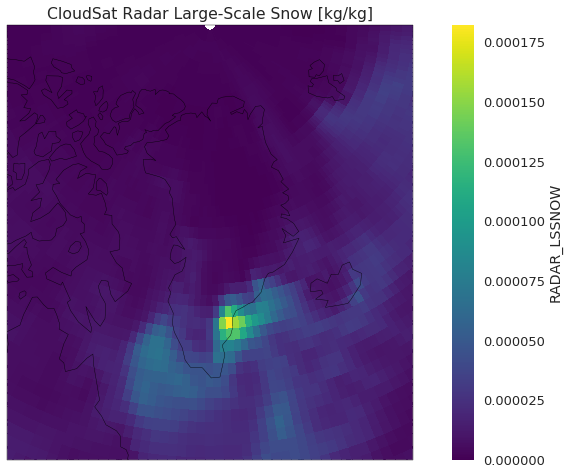

In [5]:
var = 'RADAR_LSSNOW'

f, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
ds[var].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([290, 340, 50, 90])
ax.coastlines()
t = ax.set_title(ds[var].long_name+' [%s]' % ds[var].units)

### A mean month in the data
An attempt to average all months throughout the years to get a climatological seasonal perspective. First I will definte a function to identically plot all of my desired variables.

In [6]:
def meantime_plots(var, time, **kwargs):
    '''
    meanmonth_plots
    A work in progress function to facet out yearly averaged individual months of these CESM monthly data.
    time = 'month', 'season', etc.
    '''
    if time == 'season':
        p = (ds[var]
             .groupby('time.%s' % time)
             .mean('time')
             .sel(season=['DJF', 'MAM', 'JJA', 'SON'])
             .plot.pcolormesh(
                 transform=ccrs.PlateCarree(), col=time, vmax=100,
                 subplot_kws={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
        )
    
    else:
        p = (ds[var]
             .groupby('time.%s' % time)
             .mean('time')
             .plot.pcolormesh(
                 transform=ccrs.PlateCarree(), col=time, vmax=100,
                 subplot_kws={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
        )
    
    p.fig.suptitle('%s [%s]' % (ds[var].long_name, ds[var].units), fontsize=14, y=1.005)
    
    for ax in p.axes.flat:
        ax.coastlines()
        ax.set_extent([290, 340, 55, 85])
        
    p.fig.savefig('../figures/explore/mean%s/%s.png' % (time, var))

---
Let's start working towards some goals.
* Annual mean precip/classes
* Seasonal maps 
* Seasonal cycle time series

Here I need to combine two of Jen's outputs to line up with her categories in the submitted paper. For now I may separate this back into the original categories after our 03/01/2018 meeting.

I will plot my five categories for direct comparison, along with the other fractions of mixed or no precipitation. Also available is `RADAR_UN` uncertain precipitation fraction, but this held no information. After exploring intially, I've removed the mostly irrelevant categories.

In [7]:
radar_vars = ['RADAR_RAINPOSS', 'RADAR_RAINPROB', 'RADAR_RAINCERT', 'RADAR_SNOWPOSS', 'RADAR_SNOWCERT']

Now I will look at the annual average of these categories of precipitation.

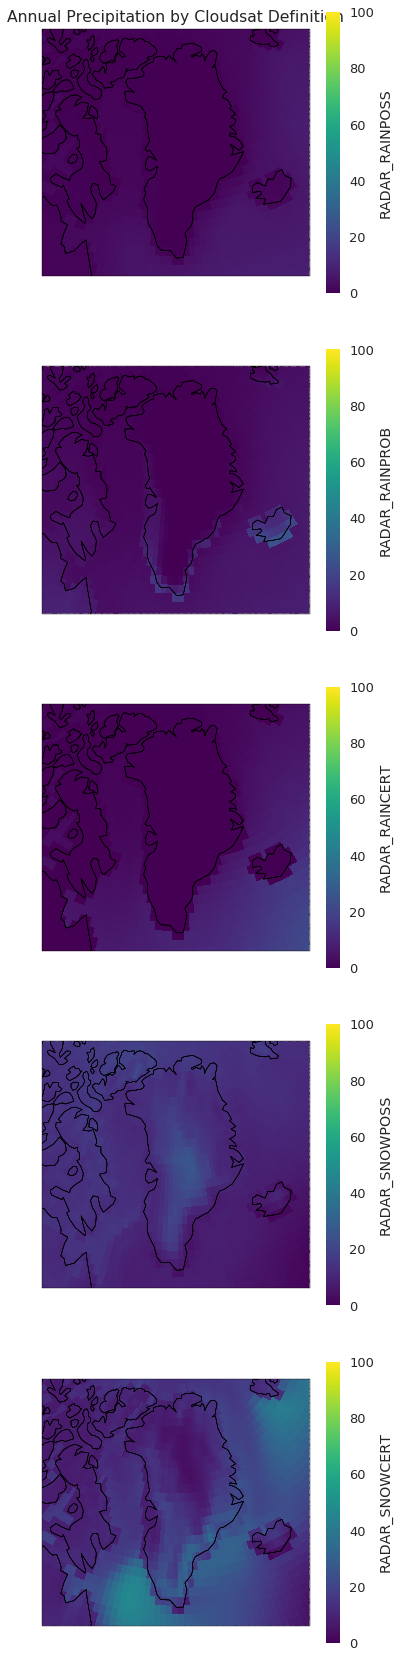

In [8]:
f, axes = plt.subplots(len(radar_vars), 1, figsize=(6, 30), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

for i, var in enumerate(radar_vars):
    p = ds[var].mean('time').plot.pcolormesh(ax=axes[i], transform=ccrs.PlateCarree(), vmax=100)
    
    for ax in axes:
        ax.coastlines()
        ax.set_extent([290, 340, 55, 85])
        
    axes[0].set_title('Annual Precipitation by Cloudsat Definition', y=1.005)

f.savefig('../figures/explore/annual_maps.png')

And here I will revisit my seasonal analysis but again for each separate category of precipitation.

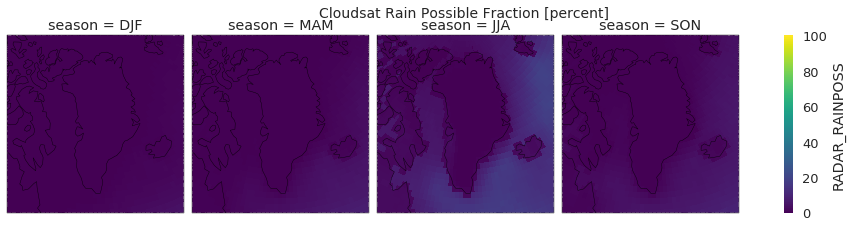

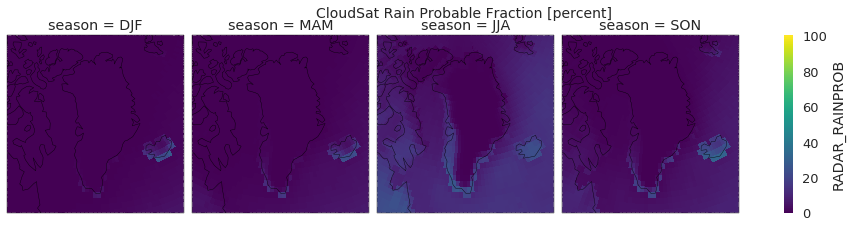

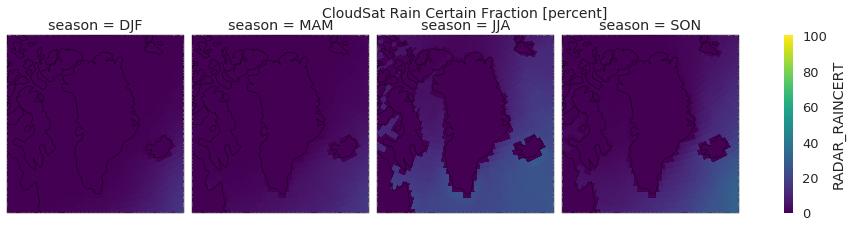

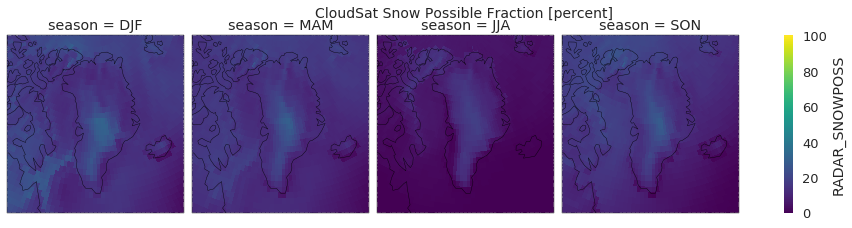

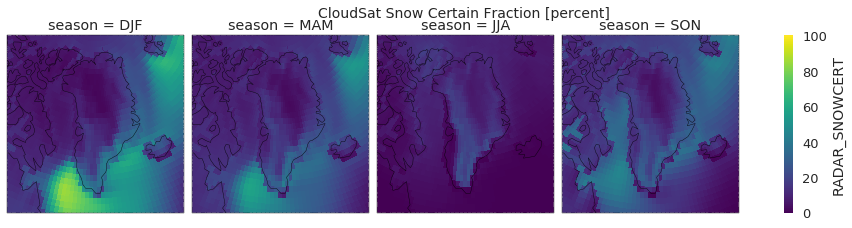

In [9]:
for var in radar_vars:
    meantime_plots(var, 'season')

Now I will read in the Jan's provided Greenland mask to take the weighted spatial average of these outputs over the Greenland ice sheet. First I will read in the mask and NaN any zero-fractions to exclude them from calculations. Afterwards I will create a weight array from the given latitude weights applied over my 1.25 deg longitude grids. **NOTE** Divide by 2.

In [10]:
ms = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = ms.where(ms > 0)

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [11]:
w = np.tile((ds['gw'][0]*1.25/360), [len(ds['lon']), 1]).T

In [12]:
ds_w = (ds[[var for var in radar_vars if var not in ('RADAR_NORAIN', 'RADAR_MIXPOSS', 'RADAR_MIXCERT')]]
        * ms.values * w).sum('lat').sum('lon') / 2

Finally, the plot of our relevant Greenland ice sheet spatially weighted average time series.

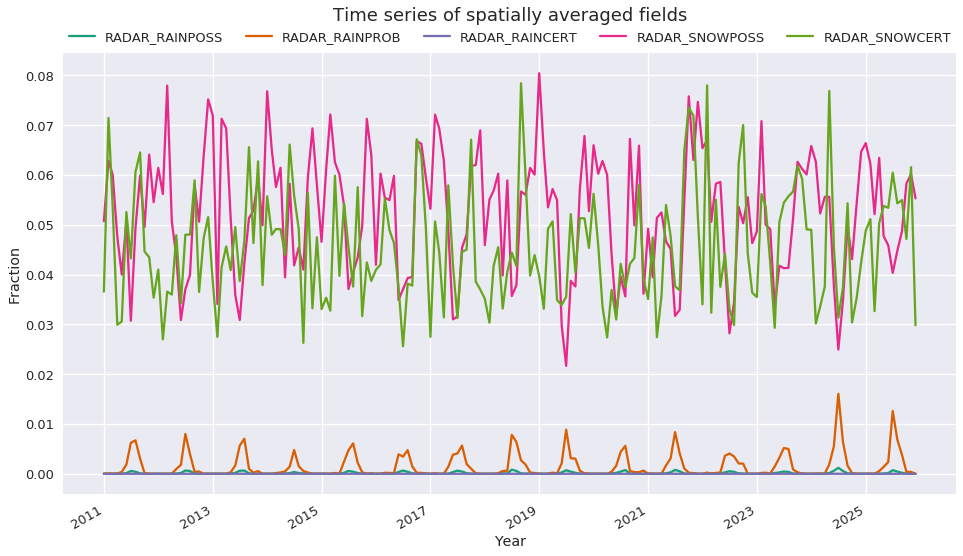

In [13]:
f, ax = plt.subplots(figsize=(16, 9))
for (i, var) in enumerate(ds_w.data_vars):
    ds_w[var].plot(ax=ax, label=('%s' % var),
                   color=sns.color_palette('Dark2', len(ds_w.data_vars))[i])
    
ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=len(ds_w.data_vars), mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Year')
ax.set_title('Time series of spatially averaged fields', y=1.06, fontsize=18)
f.savefig('../figures/explore/GIS-average_tseries.png')

---
Now I will take a look at this time series for an average year of this data.

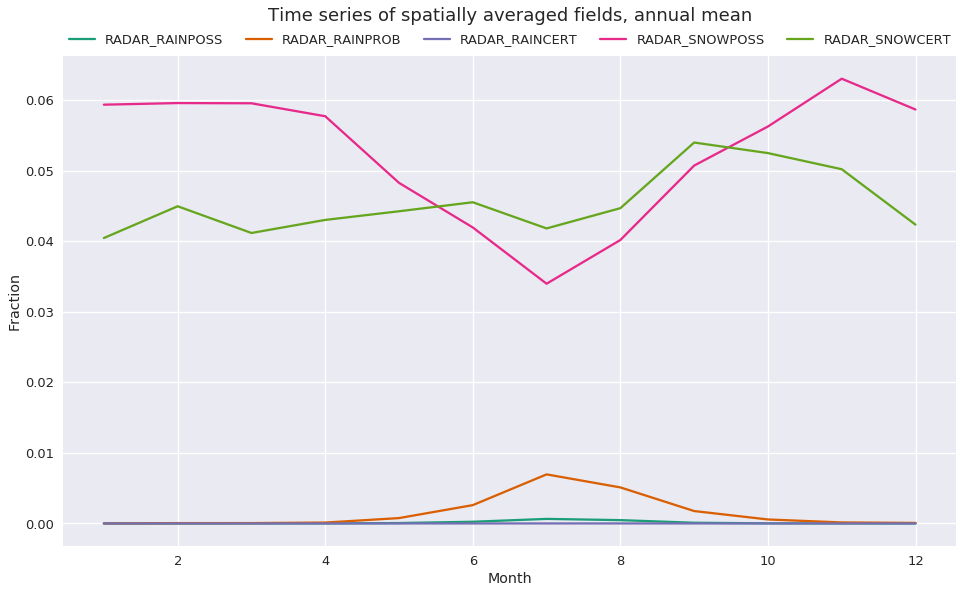

In [14]:
f, ax = plt.subplots(figsize=(16, 9))
for (i, var) in enumerate(ds_w.data_vars):
    (ds_w[var].groupby('time.month')
              .mean('time')
              .plot(ax=ax, label=('%s' % var), color=sns.color_palette('Dark2', len(ds_w.data_vars))[i]))
    
ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=len(ds_w.data_vars), mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Month')
ax.set_title('Time series of spatially averaged fields, annual mean', y=1.06, fontsize=18)
f.savefig('../figures/explore/GIS-average_tseries_annual.png')